<h1>Feature Engineering & Random Forest Model Training</h1>
Author: Joshua White  

This notebook will handle the feature engineering for my CSCE 623 project. The steps followed are:  
1. **Label coding**: creation of a dictionaryto map each category to a code.  
2. **Text representation**: use of TF-IDF scores to represent the text.  

A number of things have already been done to the data set before this process happens. First the actual text was cleaned to include removing of any html tags, turned to lowercase, punctuation was removed, tokenized, and lemmatization. Then the entire data set was split into a 80-20% split of training and test data. Then that training subset was split up into training and validation subsets for k-fold cross validation, with k = 5.

After this the TF-IDF vectors are used to train a Random Forest Model. 

**Source**: 
I used the following article for a lot of this process: 
https://towardsdatascience.com/text-classification-in-python-dd95d264c802

In [1]:
import pickle
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

In [2]:
# Setting up some variables to be used:
input_training = "training_data_nyc-jobs.csv"

input_training_0 = "training_set_0.csv"
input_training_1 = "training_set_1.csv"
input_training_2 = "training_set_2.csv"
input_training_3 = "training_set_3.csv"
input_training_4 = "training_set_4.csv"

input_validation_0 = "validation_set_0.csv"
input_validation_1 = "validation_set_1.csv"
input_validation_2 = "validation_set_2.csv"
input_validation_3 = "validation_set_3.csv"
input_validation_4 = "validation_set_4.csv"

input_test = "test_data_nyc-jobs.csv"

# Load the first training and validation sets into a data frame
DF_train = pd.read_csv(input_training)
DF_test = pd.read_csv(input_test)

In [3]:
# Just to look at the data frame:
DF_train.head()

,job_id,agency,posting_type,no_of_positions,business_title,civil_service_title,title_code_no,level,job_category,category,...,additional_information,to_apply,hours_shift,work_location_1,residency_requirement,posting_date,post_until,posting_updated,process_date,processed_text
0,424627,DEPARTMENT OF TRANSPORTATION,Internal,3,Capital Budget Analyst,ASSOCIATE STAFF ANALYST,12627,0,"Finance, Accounting, & Procurement",7,...,***IN ORDER TO BE CONSIDERED FOR THIS POSITION...,All resumes to be submitted electronically usi...,Office Hours: 9AM-5PM,55 Water St Ny Ny,New York City residency is generally required ...,2019-12-06T00:00:00.000,2019-12-26T00:00:00.000,2019-12-06T00:00:00.000,2019-12-17T00:00:00.000,capital budget analyst order considered positi...
1,423479,POLICE DEPARTMENT,Internal,2,City Custodial Assistant,CITY CUSTODIAL ASSISTANT,90644,0,Building Operations & Maintenance,2,...,This lateral opportunity is open to current Ci...,Please submit your resume and cover letter. P...,Shift depends on the Command.,Positions are available in the following comma...,New York City residency is generally required ...,2019-12-09T00:00:00.000,2020-01-23T00:00:00.000,2019-12-13T00:00:00.000,2019-12-17T00:00:00.000,city custodial assistant candidate selected re...
2,376405,NYC HOUSING AUTHORITY,Internal,1,Assistant Director for LHD Budget & Personnel,ADMINISTRATIVE STAFF ANALYST (,1002D,0,"Administration & Human Resources Policy, Resea...",1,...,"Employees applying for promotional, title or l...","Click the ""Apply Now"" button.",0,0,NYCHA has no residency requirements.,2019-05-21T00:00:00.000,0,2019-07-30T00:00:00.000,2019-12-17T00:00:00.000,assistant director budget personnel financial ...
3,397520,DEPT OF ENVIRONMENT PROTECTION,Internal,2,Plant Chief,SENIOR STATIONARY ENGINEER (EL,91639,0,"Engineering, Architecture, & Planning",6,...,Appointments are subject to OMB approval. For...,"Click ""Apply Now"" button",40 hours per week/day,Citywide,New York City residency is generally required ...,2019-06-10T00:00:00.000,0,2019-06-21T00:00:00.000,2019-12-17T00:00:00.000,plant chief department environmental protectio...
4,425079,DEPT OF ENVIRONMENT PROTECTION,Internal,1,Bureau Energy Manager,CITY RESEARCH SCIENTIST,21744,3,"Engineering, Architecture, & Planning Policy, ...",6,...,DEP is an equal opportunity employer with a st...,Click on â€œApply Nowâ€ and submit a resume a...,35 hours per week,"59-17 Junction Blvd, Corona NY",New York City residency is generally required ...,2019-12-10T00:00:00.000,0,2019-12-10T00:00:00.000,2019-12-17T00:00:00.000,bureau energy manager department environmental...


<h2>1. Label Coding</h2>
Now create a dictionary with the label codification. These codes are already in our data set in the 'category' column. 

In [4]:
category_codes = {
    'admin' : 1,
    'maintenance' : 2,
    'clerical' : 3,
    'communications' : 4,
    'community' : 5,
    'engineering' : 6,
    'finance' : 7,
    'health' : 8,
    'technology' : 9,
    'legal' : 10,
    'policy' : 11,
    'public_safety' : 12
}

<h2>2. Text representation</h2>
There are many different ways to represent the text we have, but we are going to choose a Bag of Words approach, specifically using TF-IDF vectors as features approach.  

We have a few different tuning knobs for the TF-IDF vectors that we need to set:  
* `ngram_range`:We want to consider both unigrams and bigrams.  
* `max_df`:When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold  
* `min_df`:When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.  
* `max_features`:If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.  

We are implicityly scaling our data when representing it as TF-IDF features with the argument `norm`.

In [5]:
# Parameter setup:
ngram_range = (1,2) # Both unigrams and bigrams
min_df = 10
max_df = 1.
max_features = 300

These parameter values are a first approximation and can be changed later if required. 

Note: In this next block we fit and then transform the training set, but **only transform the validation set**. 

In [6]:
# Set up the X and Y data for the training and validation sets
X_train = DF_train['processed_text']
Y_train = DF_train['category']

X_test = DF_test['processed_text']
Y_test = DF_test['category']


# Set up the TF-IDF vectorizer object
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

features_train = tfidf.fit_transform(X_train).toarray()
labels_train = Y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = Y_test
print(features_test.shape)

(1328, 300)
(331, 300)


We can use the Chi squared test in order to see what unigrams and bigrams are most correlated with each category: 

In [7]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'admin' category:
  . Most correlated unigrams:
. training
. latitude
. associate
. personnel
. administrative
  . Most correlated bigrams:
. design construction
. project manager

# 'clerical' category:
  . Most correlated unigrams:
. attorney
. record
. delivery
. assigned
. associate
  . Most correlated bigrams:
. civil service
. special project

# 'communications' category:
  . Most correlated unigrams:
. specialist
. lead
. stakeholder
. strategy
. communication
  . Most correlated bigrams:
. design construction
. city agency

# 'community' category:
  . Most correlated unigrams:
. housing
. center
. education
. community
. outreach
  . Most correlated bigrams:
. drinking water
. per day

# 'engineering' category:
  . Most correlated unigrams:
. water
. design
. construction
. engineer
. engineering
  . Most correlated bigrams:
. project manager
. design construction

# 'finance' category:
  . Most correlated unigrams:
. payment
. procurement
. budget
. analyst
. financial
  . M

In [8]:
# To see all of the bigrams produced:
bigrams

['special project',
 'new york',
 'project manager',
 'city department',
 'city agency',
 'york city',
 'civil service',
 'per day',
 'include limited',
 'high quality',
 'country nearly',
 'nearly employee',
 'pollution combined',
 'combined municipal',
 'utility country',
 'noise hazardous',
 'reducing air',
 'material pollution',
 'quality drinking',
 'municipal water',
 'air noise',
 'water utility',
 'hazardous material',
 'department environmental',
 'water supply',
 'environmental protection',
 'billion gallon',
 'water sewer',
 'drinking water',
 'public health',
 'selected candidate',
 'design construction',
 'responsibility include']

<h2>Cross-Validation for Hyperparameter Tuning</h2>
First, we can see what hyperparameters the model has:  

In [9]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:  

* `n_estimators` = number of trees in the forest.  
* `max_features` = max number of features considered for splitting a node  
* `max_depth` = max number of levels in each decision tree  
* `min_samples_split` = min number of data points placed in a node before the node is split  
* `min_samples_leaf` = min number of data points allowed in a leaf node  
* `bootstrap` = method for sampling data points (with or without replacement)  

<h2>Randomized Search Cross Validation</h2>
First define the grid:

In [10]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


Then, perform the Random Search:

In [11]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=5, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs = 3)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.5min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

You can check the best hyperparameters with the code below:

In [12]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.7198808341608739


<h2>Grid Search Cross Validation</h2>

In [13]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [1000]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 5, test_size = .2, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1,
                           n_jobs = 3
                          )

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:  4.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=8, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sample...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=8,
                                  

Again lets print out the results of the best hyperparameters:

In [14]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}

The mean accuracy of a model with these hyperparameters is:
0.7090225563909774


And let's save the model in a variable called best_rfc here:

In [15]:
best_rfc = grid_search.best_estimator_

In [16]:
# We can call this to have a look at our current parameter settings:
best_rfc

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

<h2>Model Fit and Performance</h2>
Now we can fit the model to our training data:

In [17]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

Now get the predictions:

In [18]:
rfc_pred = best_rfc.predict(features_test)

If you wanted the conditional class probabilities they could be obtained by typing:

rfc_pred = best_rfc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

**Training Accuracy**

In [19]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.9962349397590361


**Test Accuracy**

In [20]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.7462235649546828


**Classification Report**
Remember our classes are:
'admin' : 1,
'maintenance' : 2,
'clerical' : 3,
'communications' : 4,
'community' : 5,
'engineering' : 6,
'finance' : 7,
'health' : 8,
'technology' : 9,
'legal' : 10,
'policy' : 11,
'public_safety' : 12

In [24]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred, zero_division = 0))

Classification report
              precision    recall  f1-score   support

           1       0.56      0.51      0.54        35
           2       0.82      0.61      0.70        23
           3       0.00      0.00      0.00         4
           4       0.50      0.20      0.29         5
           5       0.82      0.56      0.67        32
           6       0.76      0.99      0.86        72
           7       0.82      0.72      0.77        25
           8       0.79      0.85      0.82        27
           9       0.76      0.95      0.85        41
          10       0.74      0.76      0.75        33
          11       0.78      0.41      0.54        17
          12       0.65      0.76      0.70        17

    accuracy                           0.75       331
   macro avg       0.67      0.61      0.62       331
weighted avg       0.74      0.75      0.73       331



**Confusion Matrix**

In [25]:
category_codes.keys()

dict_keys(['admin', 'maintenance', 'clerical', 'communications', 'community', 'engineering', 'finance', 'health', 'technology', 'legal', 'policy', 'public_safety'])

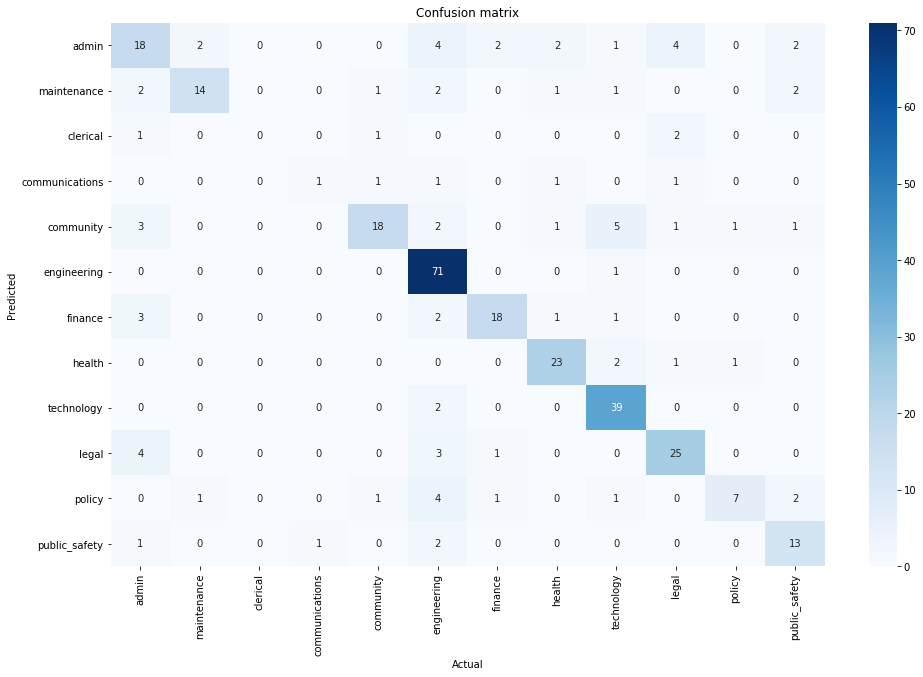

In [33]:
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=category_codes.keys(), 
            yticklabels=category_codes.keys(),
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Now we can check to see if they hyperparameter tuning process returned a better model:

In [27]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.7341389728096677

In [28]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.7462235649546828

We can create a dataset with a model summary to compare the models later:

In [29]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [30]:
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.996235,0.746224


We can also save the model and the data set with pickle:

In [32]:
with open('Models/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open('Models/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)

The following site had some promising information to further produce graphs for the grid search cross validation. 
https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv